In [1]:
import warnings #负担数据集运行及过拟合检验用的代码---随机森林！（可替换LGB，树模型不需要归一化）
warnings.filterwarnings("ignore")

In [2]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm,trange
import random
from lightgbm import LGBMClassifier, LGBMRegressor

%matplotlib inline

In [3]:
def scatter_loss_plot():
    plt.subplot(1,2,1)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_test[colnames[0]],y_test_pred[0],'.')

    
    plt.subplot(1,2,2)
    plt.ylim(-1,1)
    plt.xlim(-1,1)
    plt.plot(y_train[colnames[0]],y_train_pred[0],'.')

    
def rmse(obs,pre):
    return np.sqrt(mean_squared_error(obs, pre))
    
def caculate_cor():
    global r_test,r_train,y_test_pred,y_train_pred,rmse_test,rmse_train
    y_test_pred=pd.DataFrame(model.predict(x_test).reshape(y_test.shape),index=test_index)
    r_test=np.corrcoef(y_test_pred[0],y_test[colnames[0]])
    y_train_pred=pd.DataFrame(model.predict(x_train).reshape(y_train.shape),index=train_index)
    r_train=np.corrcoef(y_train_pred[0],y_train[colnames[0]])
    rmse_test=rmse(y_test[colnames[0]],y_test_pred[0])
    rmse_train=rmse(y_train[colnames[0]],y_train_pred[0])

In [4]:
import joblib
#xl = pd.ExcelFile('burden20230616.xlsx')
#namelist=xl.sheet_names[1:13]
#predf=pd.read_excel('experiment materials.xlsx',sheet_name=1).iloc[0:5,0:31]

writer1=pd.ExcelWriter('b-all-rf-op.xlsx')
writer2=pd.ExcelWriter('b-all-rf-cor.xlsx')
writer3=pd.ExcelWriter('b-all-rf-imp.xlsx')
writer4=pd.ExcelWriter('b-all-pre.xlsx')
writer5=pd.ExcelWriter('b-all-val.xlsx')

In [5]:
for i in trange(1,4):
    #frame=pd.read_excel('RF20210202.xlsx',sheet_name=i)
    frame=pd.read_excel('burden20230616.xlsx',sheet_name=i)
    random.seed(i)
    val=random.sample(range(0,len(frame)),5)           #随机抽取所有数据中的5个样本
    model_index=list(frame.index)

    for j in val:
        model_index.remove(j)
    valdata=frame.loc[val,:]
    val_x=valdata.iloc[:,1:29]
    val_y=valdata.iloc[:,29:]
    frame=frame.loc[model_index,:]
    x_data=frame.iloc[:,1:29]
    #x_data=frame[globals()['colindex'+str(i)]]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,29:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    
    
    #stdsc=StandardScaler()
    prelist=[]
    vallist=[]
    corlist_train=[]
    corlist_test=[]
    rmsel_train=[]
    rmsel_test=[]
    o=[]
    imp=[]
    

    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,max_features=5)  #,min_samples_leaf=2)
    #model=LGBMRegressor(learning_rate=0.31, max_depth=10,random_state=0)
    
    
    
    #with tqdm(total=10) as pbar:
    for train_index , test_index in ss.split(x_data,y_data):
        x_train=x_data.iloc[train_index,:]
        x_train.columns=x_names
        
        y_train=y_data.iloc[train_index,:]
        
        x_test=x_data.iloc[test_index,:]
        x_test.columns=x_names
    
        y_test=y_data.iloc[test_index,:]
        
        model.fit(x_train,np.array(y_train).ravel())       #模型拟合
        
        
        joblib.dump(model, f'D:/策划类/01NKU/机器学习中的因果推断/因果机器学习/12第12次组会文献/代码运行数据保存/RF-new-data/R-B-model-{i}.pkl')
        
        val_one=model.predict(val_x)
        
        vallist.append(val_one.T)
        #pre_one=model.predict(predf)
        #prelist.append(pre_one.T)
        caculate_cor()
        corlist_train.append(r_train[1,0])
        corlist_test.append(r_test[1,0])
        rmsel_train.append(rmse_train)
        rmsel_test.append(rmse_test)
       # scatter_loss_plot()
        o.append(y_train[colnames[0]])
        o.append(y_train_pred[0])
        o.append(y_test[colnames[0]])
        o.append(y_test_pred[0])
        #pbar.update()           
        imp.append(model.feature_importances_)

    #plt.show()        
    cordf=pd.DataFrame({'train':corlist_train,'test':corlist_test,
                        'rmse_train':rmsel_train,'rmse_test':rmsel_test})
    obs_pre_df=pd.DataFrame([y_data[colnames[0]],o[1],o[5],o[9],o[13],o[17],o[21],o[25],o[29],o[33],o[37],
                            o[3],o[7],o[11],o[15],o[19],o[23],o[27],o[31],o[35],o[39]]).T
    obs_pre_df.columns=(colnames[0],'train1','train2','train3','train4','train5',
                        'train6','train7','train8','train9','train10',
                        'test1','test2','test3','test4','test5',
                        'test6','test7','test8','test9','test10')
    presult=pd.DataFrame(prelist,columns=['T','C','S','M','L']).T
    vresult=pd.DataFrame(vallist,columns=val).T
    
    print(np.corrcoef(np.array(np.mean(vresult.T)).ravel(),
                          np.array(val_y).ravel())[0,1])
    vresult['predict']=np.array(np.mean(vresult.T)).ravel()
    vresult['observe']=val_y
    vresult['error']=vresult['predict']-vresult['observe']

    #imp_df=pd.DataFrame(imp,columns=globals()['colindex'+str(i)])
    imp_df=pd.DataFrame(imp,columns=x_names)
    obs_pre_df.to_excel(writer1,sheet_name=colnames[0])
    cordf.to_excel(writer2,sheet_name=colnames[0])
    imp_df.to_excel(writer3,sheet_name=colnames[0])
    presult.to_excel(writer4,sheet_name=colnames[0])
    vresult.to_excel(writer5,sheet_name=colnames[0])
    
writer1.save()
writer2.save()
writer3.save()
writer4.save()
writer5.save()

 33%|████████████████████████████                                                        | 1/3 [00:10<00:21, 10.97s/it]

0.9800310805324761


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:19<00:09,  9.78s/it]

0.9914467611123788


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.46s/it]

0.9654965019140345


# permutation test

In [7]:
writer1=pd.ExcelWriter('Burden-permutation.xlsx')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:06<00:26,  6.69s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:20,  6.70s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:20<00:13,  6.88s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:27<00:06,  6.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.95s/it]

 10%|████████▎                                                                          | 1/10 [00:35<05:18, 35.42s/it]

  0%|                           

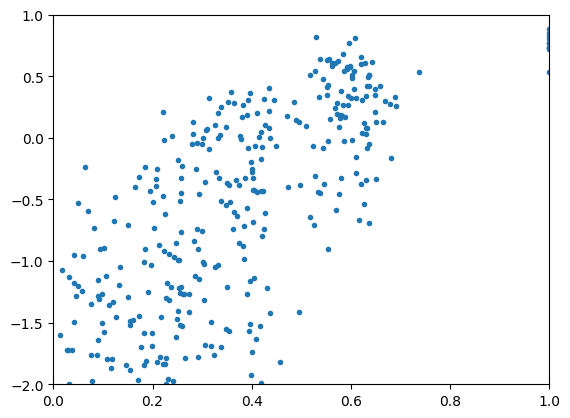

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:06<00:25,  6.43s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:13<00:19,  6.54s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:19<00:12,  6.47s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:25<00:06,  6.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]

 10%|████████▎                                                                          | 1/10 [00:32<04:53, 32.63s/it]

  0%|                           

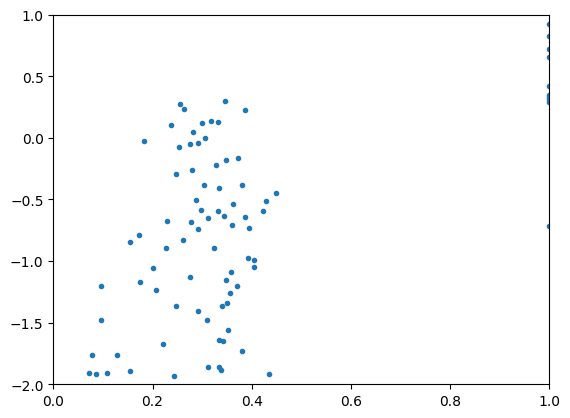

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

 20%|████████████████▊                                                                   | 1/5 [00:05<00:23,  5.89s/it]

 40%|█████████████████████████████████▌                                                  | 2/5 [00:12<00:18,  6.19s/it]

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:18<00:12,  6.23s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.14s/it]

 10%|████████▎                                                                          | 1/10 [00:31<04:41, 31.24s/it]

  0%|                           

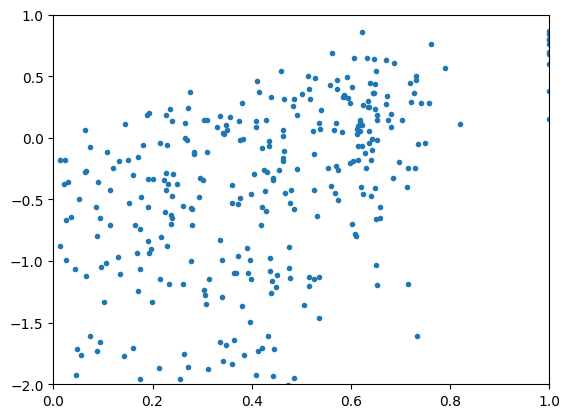

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [16:13<00:00, 324.57s/it]


In [8]:
for i in trange(3):
    frame=pd.read_excel('clearance2023.xlsx',sheet_name=i+2)
    random.seed(i)
    val=random.sample(range(0,len(frame)),5)
    model_index=list(frame.index)
    for j in val:
        model_index.remove(j)
    #x_data=frame[globals()['colindex'+str(i)]]
    valdata=frame.iloc[val,:]
    val_x=valdata.iloc[:,1:29]
    val_y=valdata.iloc[:,29:]
    frame=frame.iloc[model_index,:]
    x_data=frame.iloc[:,1:29]
    x_data.index=range(len(x_data))
    y_data=frame.iloc[:,29:]
    y_data.index=range(len(y_data))
    x_names=x_data.columns.values.tolist()
    colnames=y_data.columns.values.tolist()
    
    ss=ShuffleSplit(n_splits=10, test_size=0.1,random_state=0)
    r2_list=[]
    q2_list=[]
    model=RandomForestRegressor(n_estimators=500,oob_score=True,random_state=0,
                                max_features=5#,min_samples_leaf=2
                                )
    with tqdm(total=10) as pbar:
        for train_index , test_index in ss.split(x_data,y_data):
            x_train=x_data.iloc[train_index,:]
            x_train.columns=x_names
            y_train=y_data.iloc[train_index,:]
            x_test=x_data.loc[test_index,:]
            x_test.columns=x_names        
            y_test=y_data.loc[test_index,:]
            
            for j in trange(5):
                for k in range(10):
                    random.seed(i+j+k)
                    per_index=np.random.choice(train_index,round((j+1)*0.2*len(x_train)),False)
                    y_train_per=y_train.copy()
                    for i_index in per_index:
                        y_train_per.loc[i_index,:]=np.random.uniform(0,max(y_data[colnames[0]]))
                    model.fit(x_train,np.array(y_train_per).ravel())
                    r2_list.append(
                        np.corrcoef(y_train.iloc[:,0],y_train_per.iloc[:,0])[0,1])
                    y_array=np.array(y_test).ravel()
                    rss=np.sum((y_array-model.predict(x_test))**2)                          
                    tss=np.sum((y_array-np.mean(y_array))**2)
                    q2=1-rss/tss
                    q2_list.append(q2)
                
            model.fit(x_train,np.array(y_train).ravel())
            r2_list.append(1)
            rss=np.sum((y_array-model.predict(x_test))**2)                          
            tss=np.sum((y_array-np.mean(y_array))**2)
            q2=1-rss/tss
            q2_list.append(q2)
            pbar.update() 
             
    perdf=pd.DataFrame({'r2':r2_list,'q2':q2_list})
    
    plt.ylim(-2,1)
    plt.xlim(0,1)
    plt.plot(perdf['r2'],perdf['q2'],'.')
    plt.show()
    perdf.to_excel(writer1,sheet_name=colnames[0])
writer1.save()